# HOMO-LUMO Energy Gap Prediction using RDKit Molecular descriptors<br>
<b>HOMO</b> stands for <i>highest occupied molecular orbital</i> and <b>LUMO</b> stands for <i> lowest unoccupied molecular orbital</i>. HOMO-LUMO molecular orbitals are called frontier molecular orbitals. They are involved in chemical bond formation. Especially, pericyclic reactions such as cycloaddition, electrocyclic reactions, and sigmatropic rearrangement are explained using HOMO-LUMO molecular orbitals. In addition, in UV-Visible spectroscopy, the absorbance of organic molecules that have extended conjugated double bonds can be rationalized using the HOMO-LUMO energy gap of the molecules.
<div>
    <img src="https://github.com/gashawmg/RDKit-descriptors-for-HOMO-LUMO-energy-gap-prediction/blob/main/plainHOMO-LUMOEnegygap%20.jpg?raw=1" width="400")>
</div>

In [62]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
#----------------------------------------------------
import pandas as pd
import numpy as np
#----------------------------------------------------
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
#----------------------------------------------------
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sn
#----------------------------------------------------
# https://github.com/shankarpandala/lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [63]:
# import session_info
# session_info.show()

# Part I - Generate Molecular Descriptors from SMILES

In [64]:
# https://zivgitlab.uni-muenster.de/m_kueh11/fp-dm-tool
# File with SMILES and HOMO-LUMO energy gap values
# Originally an excel file, but converted it to csv file 
# https://www.sciencedirect.com/science/article/pii/S2451929420300851

dataset = pd.read_csv('Orbital_Energies_input_data.csv')
dataset.shape

(2904, 2)

In [65]:
dataset.head()

,SMILES,Energygap
0,Cc1ccc(cc1)C(F)(F)F,197.75
1,OC(=O)CCCCl,247.49
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.71
3,Nc1ccc(Cl)c(Cl)c1,169.03
4,C[C@@H](CCO)CCC=C(C)C,209.57


## 1. Generate canonical SMILES

In [66]:
# There might be one or more valid SMILES that can represent one compound
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles] 
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

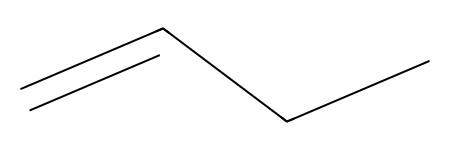

In [67]:
a = Chem.MolFromSmiles('C=CCC')
a

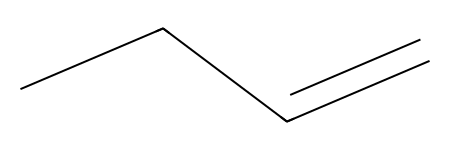

In [68]:
b = Chem.MolFromSmiles('CCC=C')
b

In [69]:
a==b

False

In [70]:
c = canonical_smiles(['C=CCC'])
c

['C=CCC']

In [71]:
d = canonical_smiles(['CCC=C'])
d

['C=CCC']

In [72]:
c==d

True

In [73]:
# Canonical SMILES
Canon_SMILES = canonical_smiles(dataset.SMILES)
len(Canon_SMILES)

2904

In [74]:
# Put the smiles in the dataframe
dataset['SMILES'] = Canon_SMILES
dataset

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.75
1,O=C(O)CCCCl,247.49
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.71
3,Nc1ccc(Cl)c(Cl)c1,169.03
4,CC(C)=CCC[C@@H](C)CCO,209.57
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.65
2900,Brc1cccc2sccc12,162.93
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.10
2902,c1ccc2sccc2c1,167.96


In [75]:
# Create a list for duplicate smiles
duplicates_smiles = dataset[dataset['SMILES'].duplicated()]['SMILES'].values
len(duplicates_smiles)

31

In [76]:
# Create a list for duplicate smiles
dataset[dataset['SMILES'].isin(duplicates_smiles)].sort_values(by=['SMILES'])

,SMILES,Energygap
218,C1=CCCCCCC1,214.10
2125,C1=CCCCCCC1,214.10
1901,C1CC[C@H]2CCCC[C@@H]2C1,251.14
552,C1CC[C@H]2CCCC[C@@H]2C1,251.14
554,C=CN1CCCC1=O,190.83
1808,C=CN1CCCC1=O,190.84
2203,C=Cc1ccccc1,168.47
1354,C=Cc1ccccc1,168.48
2341,C=Cc1ccccc1,168.49
1265,C=Cc1ccncc1,174.83


## 2.  Drop duplicate values

In [77]:
dataset_new = dataset.drop_duplicates(subset=['SMILES'])
len(dataset_new)

2873

In [78]:
dataset_new

,SMILES,Energygap
0,Cc1ccc(C(F)(F)F)cc1,197.75
1,O=C(O)CCCCl,247.49
2,CC(C)(Oc1ccc(CCNC(=O)c2ccc(Cl)cc2)cc1)C(=O)O,164.71
3,Nc1ccc(Cl)c(Cl)c1,169.03
4,CC(C)=CCC[C@@H](C)CCO,209.57
...,...,...
2899,c1ccc(P(CCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1,168.65
2900,Brc1cccc2sccc12,162.93
2901,CCOC(=O)N1c2ccccc2C=C[C@@H]1OCC,165.10
2902,c1ccc2sccc2c1,167.96


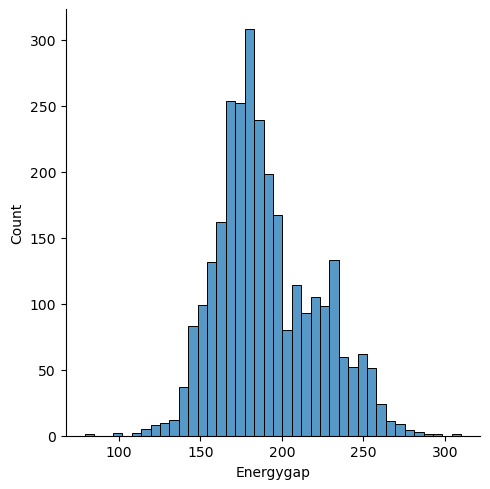

In [79]:
sn.displot(dataset_new.Energygap)

In [80]:
dataset_new.Energygap.describe()

count   2873.00
mean     190.64
std       30.66
min       78.99
25%      169.40
50%      184.80
75%      211.16
max      309.98
Name: Energygap, dtype: float64

In [81]:
np.median(dataset_new.Energygap)

184.7951254

<Axes: >

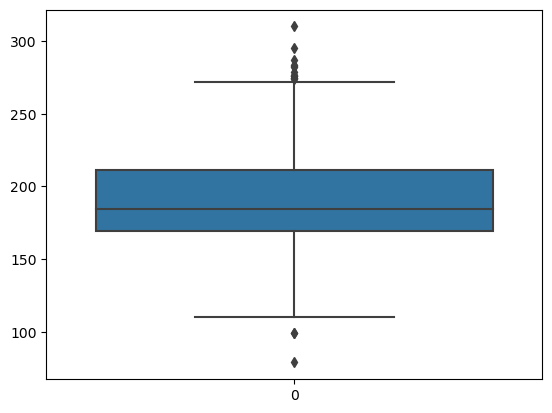

In [82]:
sn.boxplot(dataset_new.Energygap)

## Calculate descriptors using RDkit

###  General molecular descriptors-about 200 molecular descriptors

In [83]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] 
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(dataset_new['SMILES'])

In [84]:
df_with_200_descriptors = pd.DataFrame(Mol_descriptors,columns=desc_names)
df_with_200_descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.55,-5.08,12.55,1.01,0.55,160.14,153.08,160.05,60,0,...,0,0,0,0,0,0,0,0,0,0
1,10.68,-3.33,10.68,1.84,0.57,122.55,115.49,122.01,42,0,...,0,0,0,0,0,0,0,0,0,0
2,13.05,-4.11,13.05,0.72,0.79,361.82,341.67,361.11,132,0,...,0,0,0,0,0,0,0,0,0,0
3,7.40,-0.45,7.40,0.07,0.58,162.02,156.98,160.98,48,0,...,0,0,0,0,0,0,0,0,0,0
4,8.10,-4.48,8.10,1.89,0.61,156.27,136.11,156.15,66,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.51,-3.87,9.51,0.97,0.37,398.43,374.23,398.14,138,0,...,0,0,0,0,0,0,0,0,0,0
2869,7.65,-0.17,7.65,0.02,0.63,213.10,208.06,211.93,50,0,...,0,0,0,0,0,0,0,1,0,0
2870,13.02,-3.81,13.02,0.33,0.82,247.29,230.16,247.12,96,0,...,0,0,0,0,0,0,0,0,0,0
2871,7.59,-0.35,7.59,0.03,0.52,134.20,128.15,134.02,44,0,...,0,0,0,0,0,0,0,1,0,0


# Part II - HOMO-LUMO Energy gap prediction of organic compounds using machine learning

## 1. Remove highly correlated features

In [85]:
def remove_correlated_features(descriptors):
    # Calculate correlation
    correlated_matrix = descriptors.corr().abs()

    # Upper triangle of correlation matrix
    upper_triangle = correlated_matrix.where(np.triu(np.ones(correlated_matrix.shape), k=1).astype(bool))

    # Identify columns that have above 0.9 values of correlation
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] >= 0.9)]
    print(to_drop)
    descriptors_correlated_dropped = descriptors.drop(columns=to_drop, axis=1)
    return descriptors_correlated_dropped    

In [86]:
descriptors_new = remove_correlated_features(df_with_200_descriptors)
descriptors_new

['MaxAbsEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_LOGPHI', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi3n', 'Chi4n', 'Chi4v', 'LabuteASA', 'SlogP_VSA5', 'SlogP_VSA6', 'EState_VSA1', 'VSA_EState1', 'HeavyAtomCount', 'NOCount', 'NumHAcceptors', 'NumHDonors', 'MolMR', 'fr_COO2', 'fr_C_O', 'fr_Nhpyrrole', 'fr_benzene', 'fr_nitro_arom', 'fr_phenol', 'fr_phenol_noOrthoHbond']


,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.55,-5.08,1.01,0.55,160.14,60,0,0.42,-0.17,1.27,...,0,0,0,0,0,0,0,0,0,0
1,10.68,-3.33,1.84,0.57,122.55,42,0,0.30,-0.48,2.14,...,0,0,0,0,0,0,0,0,0,0
2,13.05,-4.11,0.72,0.79,361.82,132,0,0.35,-0.48,1.32,...,0,0,0,0,0,0,0,0,0,0
3,7.40,-0.45,0.07,0.58,162.02,48,0,0.16,-0.40,1.44,...,0,0,0,0,0,0,0,0,0,0
4,8.10,-4.48,1.89,0.61,156.27,66,0,0.21,-0.40,1.91,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.51,-3.87,0.97,0.37,398.43,138,0,0.06,-0.06,0.43,...,0,0,0,0,0,0,0,0,0,0
2869,7.65,-0.17,0.02,0.63,213.10,50,0,0.07,-0.14,1.40,...,0,0,0,0,0,0,0,1,0,0
2870,13.02,-3.81,0.33,0.82,247.29,96,0,0.42,-0.45,1.56,...,0,0,0,0,0,0,0,0,0,0
2871,7.59,-0.35,0.03,0.52,134.20,44,0,0.07,-0.14,1.22,...,0,0,0,0,0,0,0,1,0,0


In [87]:
# adapted from:https://github.com/dataprofessor/padel/blob/main/padelpy.ipynb

from sklearn.feature_selection import VarianceThreshold

def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

X = remove_low_variance(descriptors_new, threshold=0.1)
X

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,MolWt,NumValenceElectrons,NumRadicalElectrons,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,...,fr_amide,fr_aniline,fr_bicyclic,fr_ester,fr_ether,fr_halogen,fr_ketone,fr_ketone_Topliss,fr_methoxy,fr_para_hydroxylation
0,12.55,-5.08,1.01,160.14,60,0,1.27,11.63,-0.24,0.00,...,0,0,0,0,0,3,0,0,0,0
1,10.68,-3.33,1.84,122.55,42,0,2.14,0.00,-0.19,-0.00,...,0,0,0,0,0,1,0,0,0,0
2,13.05,-4.11,0.72,361.82,132,0,1.32,10.86,-0.24,0.00,...,1,0,0,0,1,1,0,0,0,0
3,7.40,-0.45,0.07,162.02,48,0,1.44,12.64,-0.14,0.51,...,0,1,0,0,0,2,0,0,0,0
4,8.10,-4.48,1.89,156.27,66,0,1.91,-0.00,-0.25,-0.04,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,9.51,-3.87,0.97,398.43,138,0,0.43,10.46,-0.18,-0.00,...,0,0,0,0,0,0,0,0,0,0
2869,7.65,-0.17,0.02,213.10,50,0,1.40,12.60,-0.09,0.55,...,0,0,1,0,0,1,0,0,0,0
2870,13.02,-3.81,0.33,247.29,96,0,1.56,10.13,-0.25,-0.00,...,1,1,1,0,2,0,0,0,0,1
2871,7.59,-0.35,0.03,134.20,44,0,1.22,11.25,-0.09,0.51,...,0,0,1,0,0,0,0,0,0,0


In [88]:
# Assign Features and Labels
X  # molecular features
y = dataset_new.Energygap # labels or targets

## 2.  Train-test data split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

## 3. Training and Selection of the best ML models for this problem

In [90]:
# Sklearn ML models in 2 lines of code
# 42 regression ML models

lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, prediction_tests = lregs.fit(X_train, X_test, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|█████████▊| 41/42 [04:28<00:05,  5.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11561
[LightGBM] [Info] Number of data points in the train set: 2011, number of used features: 106
[LightGBM] [Info] Start training from score 190.710045


100%|██████████| 42/42 [04:29<00:00,  6.42s/it]


In [91]:
prediction_tests

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.90,0.91,9.00,0.97
HistGradientBoostingRegressor,0.90,0.91,9.10,2.84
ExtraTreesRegressor,0.89,0.91,9.35,8.78
XGBRegressor,0.88,0.90,9.77,2.03
RandomForestRegressor,0.87,0.89,10.28,24.06
GradientBoostingRegressor,0.87,0.88,10.43,7.09
BaggingRegressor,0.85,0.87,10.91,2.57
PoissonRegressor,0.83,0.85,11.85,0.11
LassoLarsIC,0.82,0.84,12.00,0.26


# Parameter tuning of the top two models

In [92]:
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
gbr = HistGradientBoostingRegressor()

## Use the optimized parameters to predict test sets


In [93]:
# Define LGBMRegressor model
lgbm_opt =LGBMRegressor(max_depth=5,min_samples_split=4, n_estimators= 800,max_features='auto')

In [94]:
gbr_opt = HistGradientBoostingRegressor(learning_rate= 0.22)#learning_rate= 0.22

In [95]:
# Train the model and predict the energy gap using X_test 
lgbm_opt.fit(X_train, y_train)
lgbm_predict = lgbm_opt.predict(X_test)

# Train the model and predict the energy gap using X_test 
gbr_opt.fit(X_train, y_train)
gbr_predict = gbr_opt.predict(X_test)

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11512
[LightGBM] [Info] Number of data points in the train set: 2011, number of used features: 106
[LightGBM] [Info] Start training from score 190.710045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [96]:
# Take the average of the optimized predictions
ave_predict = (lgbm_predict + gbr_predict)/2

In [97]:
# Model performance using MAE
MAE = mean_absolute_error(y_test, ave_predict)
print('MAE:', MAE)

MAE: 6.031669675212837


In [98]:
df_ = pd.DataFrame()

In [99]:
df_['Actual'] = np.array(y_test)
df_['Predicted'] = ave_predict

In [100]:
df_[:50]

,Actual,Predicted
0,189.29,187.54
1,199.23,198.04
2,169.53,168.98
3,219.88,217.79
4,211.16,201.63
5,179.70,186.89
6,177.46,182.56
7,193.01,200.93
8,253.85,259.68
9,174.26,180.03


In [101]:
# R^2 (coefficient of determination) regression score function: 
R2 =r2_score(y_test, ave_predict)
print('R^2:', R2)

R^2: 0.9215413724552036


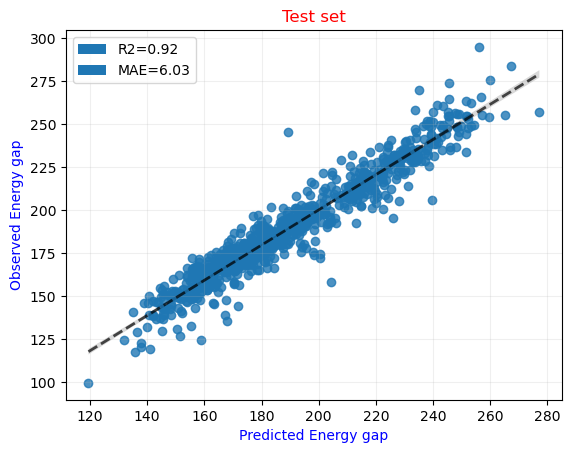

In [104]:
sn.regplot(x=ave_predict , y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Test set", color='red')
plt.grid(alpha=0.2)

# Format R2 and MAE as strings
R2_str = "{:04.2f}".format(R2)
MAE_str = "{:04.2f}".format(MAE)

# Create legend labels
R2_label = "R2={}".format(R2_str)
MAE_label = "MAE={}".format(MAE_str)

# Add legend
plt.legend(handles=[mpatches.Patch(label=R2_label), mpatches.Patch(label=MAE_label)])

# Save the plot as an SVG image
plt.savefig('plot.svg', format='svg')

# Show the plot
plt.show()

TypeError: unsupported format string passed to Patch.__format__

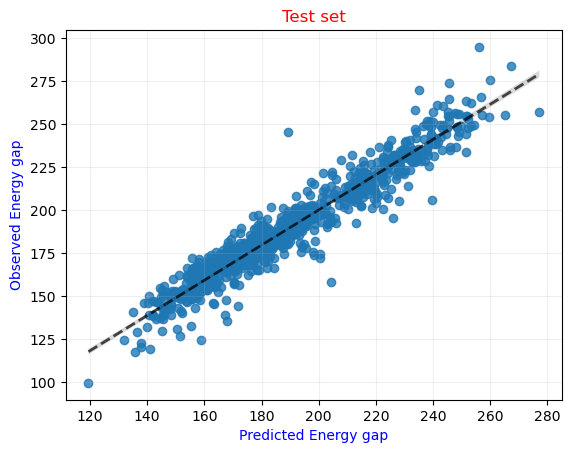

In [60]:
sn.regplot(x=ave_predict , y=y_test,line_kws={"lw":2,'ls':'--','color':'black',"alpha":0.7})
plt.xlabel('Predicted Energy gap', color='blue')
plt.ylabel('Observed Energy gap', color ='blue')
plt.title("Test set", color='red')
plt.grid(alpha=0.2)
R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
MAE = mpatches.Patch(label="MAE={:04.2f}".format(MAE))
plt.legend(handles=[R2, MAE])

# Save the plot as an SVG image
plt.savefig('plot.svg', format='svg')

# Show the plot (optional)
plt.show()

## Saving model for future use

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

import pickle
with open('lgbm_model.pkl','wb') as f:
          pickle.dump(lgbm_opt,f)
        
with open('hgbr_model.pkl','wb') as f:
          pickle.dump(gbr_opt,f)
with open('scaler.pkl','wb') as f:
          pickle.dump(scaler,f)

##  Loading the model

In [56]:
# with open('lgbm_model.pkl','rb') as f:
#     model_lgbm = pickle.load(f)
        
# with open('hgbr_model.pkl','rb') as f:
#     model_hgbr = pickle.load(f)